## Sample from a feature distribution (mimicking GC content, the length of a genomic interval, etc)

Text(0, 0.5, 'number of examples')

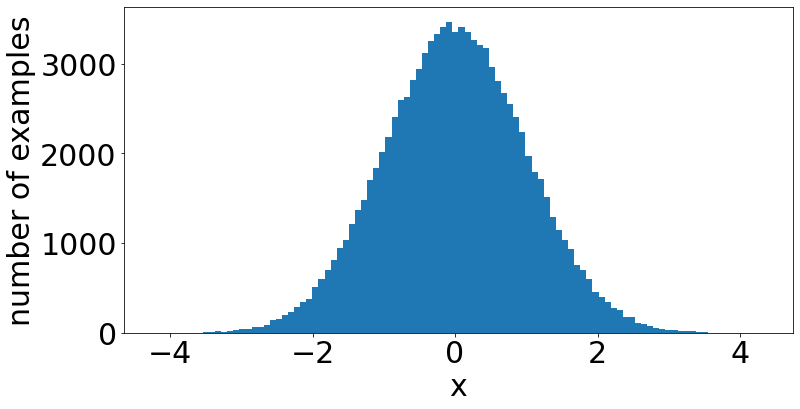

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 30})

NUMBER_EXAMPLES = 100000 # Number of intervals

# Sample from a univariate normal distribution
MEAN = 0
STD = 1
xs = np.random.normal(loc=MEAN, scale=STD, size=NUMBER_EXAMPLES)

plt.figure(figsize=(12, 6))
plt.hist(xs, bins=100)
plt.xlabel('x')
plt.ylabel('number of examples')

## True mapping from feature to target (mimicking SNV counts)

(0.0, 400.0)

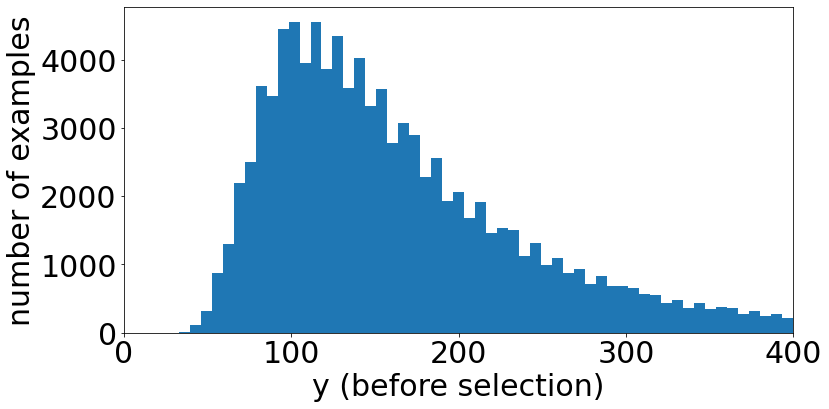

In [2]:
# parameters of true model 
A = 5
B = 0.5 
C = 0.05
TRUE_PARAMS_KEYS = ['A', 'B', 'C']
TRUE_PARAMS_VALUES = [A, B, C]

TRUE_RATE = lambda x: np.exp(A + B*x + C*x**2) # rate function

ys = np.random.poisson(lam=TRUE_RATE(xs)) # target 

plt.figure(figsize=(12, 6))
plt.hist(ys, bins=500)
plt.xlabel('y (before selection)')
plt.ylabel('number of examples')
plt.xlim(0, 400)

## Introduce selection into a small fraction of examples

In [3]:
# Take x% of the examples, declare them to be positive examples, and reduce their y values (possibly in proportion to x), 
# to mimic the effect of negative selection (and how it is stronger in regions with higher GC content, e.g., genes)

# Take the remaining examples, declare them to be neutral (negative) examples, and do not change their y values

POSITIVE_FRACTION = 0.2

num_pos = int(POSITIVE_FRACTION*NUMBER_EXAMPLES)

FRACTIONAL_REDUCTION_IN_Y = 0.2
x_factor = (xs - xs.min()) / (xs.max() - xs.min())
y_pos = ys[:num_pos] * (1 - FRACTIONAL_REDUCTION_IN_Y * x_factor[:num_pos])

# Y_DEPLETION = 25
# y_pos = np.maximum(0, ys[:num_pos] - Y_DEPLETION)

y_neg = ys[num_pos:]
ys = np.concatenate([y_pos, y_neg])

constrained = num_pos*[True] + (NUMBER_EXAMPLES-num_pos)*[False]

DATA = pd.DataFrame({'x': xs, 'y': ys, 'constrained': constrained})
DATA

,x,y,constrained
0,-1.377738,69.070583,True
1,-1.495520,56.168580,True
2,0.491378,166.362439,True
3,0.946939,230.291734,True
4,-0.896494,75.614046,True
...,...,...,...
99995,-0.576418,121.000000,False
99996,0.398183,193.000000,False
99997,2.144731,508.000000,False
99998,2.340986,643.000000,False


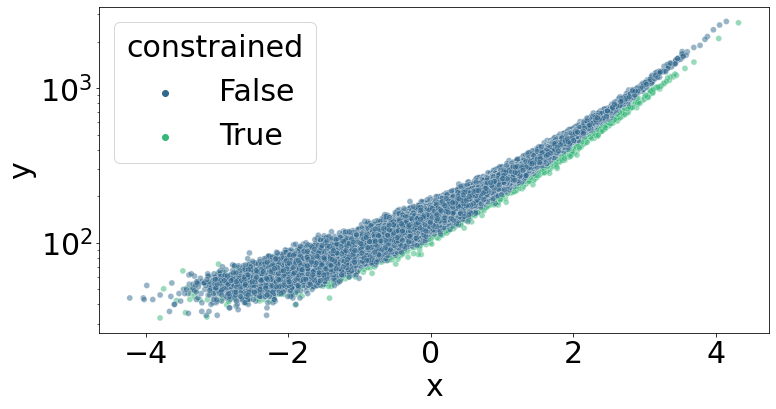

In [4]:
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.scatterplot(data=DATA, x='x', y='y', hue='constrained', palette='viridis', alpha=0.5)
plt.yscale('log')

## Fit neutral models

In [5]:
import statsmodels.api as sm

# Mute SettingWithCopyWarning
pd.options.mode.chained_assignment = None

MODEL_TYPES = ['constant', 'linear', 'quadratic'] 

def fit_poisson_model(df, model_type):
    df_neg = df[df['constrained'] == False]

    if model_type == 'constant':
        x_model_neg = np.ones((df_neg.shape[0], 1))
        x_model = np.ones((df.shape[0], 1))  
    elif model_type == 'linear':
        x_model_neg = sm.add_constant(df_neg['x'])
        x_model = sm.add_constant(df['x'])
    elif model_type == 'quadratic':
        df_neg['x2'] = df_neg['x']**2
        x_model_neg = sm.add_constant(df_neg[['x', 'x2']])
        df['x2'] = df['x']**2
        x_model = sm.add_constant(df[['x', 'x2']])
    else:
        raise ValueError(f"Unknown model type: {model_type}")
            
    neutral_model = sm.Poisson(df_neg['y'], x_model_neg).fit(disp=False)

    print(f'{model_type} model of lambda:')
    estimated_params_keys = ['alpha', 'beta', 'gamma']
    estimated_params_values = neutral_model.params.values
    for i, estimated_param_value in enumerate(estimated_params_values):
        print(f'{estimated_params_keys[i]}: {estimated_param_value:.2f} ({TRUE_PARAMS_KEYS[i]}: {TRUE_PARAMS_VALUES[i]})')
    print()
    
    df[f'predicted_y_{model_type}Model'] = neutral_model.predict(x_model)

    df[f'residuals_{model_type}Model'] = df[f'predicted_y_{model_type}Model'] - df['y']
    df[f'standardized_residuals_{model_type}Model'] = df[f'residuals_{model_type}Model']/np.sqrt(df[f'predicted_y_{model_type}Model'])
        
    return df

def fit_poison_model_wrapper(df):
    for model_type in MODEL_TYPES:
        df = fit_poisson_model(df, model_type)
    return df

DATA = fit_poison_model_wrapper(DATA)
DATA

constant model of lambda:
alpha: 5.19 (A: 5)

linear model of lambda:
alpha: 5.04 (A: 5)
beta: 0.55 (B: 0.5)

quadratic model of lambda:
alpha: 5.00 (A: 5)
beta: 0.50 (B: 0.5)
gamma: 0.05 (C: 0.05)



,x,y,constrained,predicted_y_constantModel,residuals_constantModel,standardized_residuals_constantModel,predicted_y_linearModel,residuals_linearModel,standardized_residuals_linearModel,x2,predicted_y_quadraticModel,residuals_quadraticModel,standardized_residuals_quadraticModel
0,-1.377738,69.070583,True,179.461838,110.391254,8.240406,71.745511,2.674928,0.315802,1.898163,81.945921,12.875337,1.422312
1,-1.495520,56.168580,True,179.461838,123.293257,9.203505,67.209396,11.040816,1.346747,2.236581,78.577636,22.409056,2.527983
2,0.491378,166.362439,True,179.461838,13.099398,0.977834,202.266020,35.903581,2.524505,0.241452,192.054219,25.691780,1.853883
3,0.946939,230.291734,True,179.461838,-50.829896,-3.794313,260.395249,30.103515,1.865523,0.896693,249.212941,18.921207,1.198570
4,-0.896494,75.614046,True,179.461838,103.847792,7.751954,93.689300,18.075255,1.867409,0.803701,98.688153,23.074108,2.322696
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,-0.576418,121.000000,False,179.461838,58.461838,4.364017,111.885019,-9.114981,-0.861727,0.332258,113.118046,-7.881954,-0.741085
99996,0.398183,193.000000,False,179.461838,-13.538162,-1.010587,192.078838,-0.921162,-0.066466,0.158550,182.552456,-10.447544,-0.773251
99997,2.144731,508.000000,False,179.461838,-328.538162,-24.524478,505.929914,-2.070086,-0.092033,4.599871,545.830107,37.830107,1.619231
99998,2.340986,643.000000,False,179.461838,-463.538162,-34.601860,564.096417,-78.903583,-3.322156,5.480217,629.194603,-13.805397,-0.550372


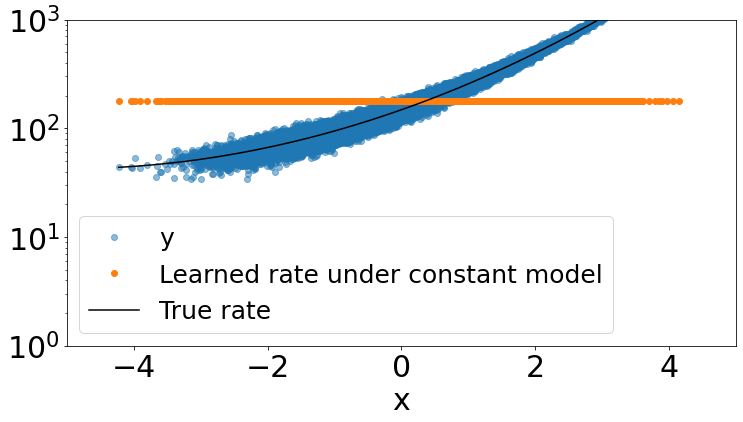

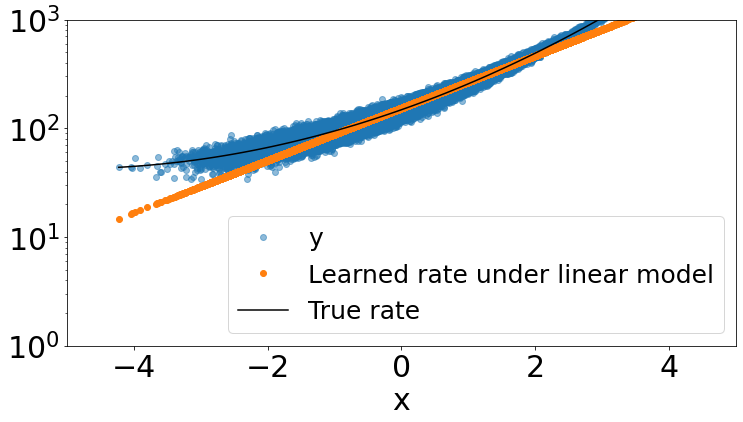

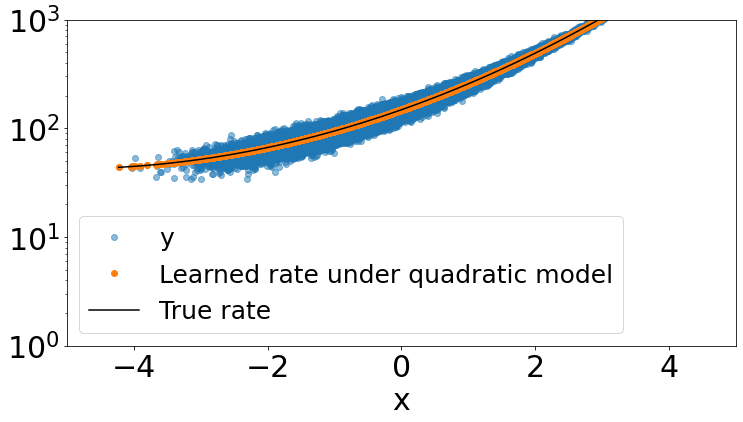

In [6]:
def plot_y(df, model_type):
    df = df[df['constrained'] == False]

    x_ = np.linspace(df['x'].min(), df['x'].max(), 100)
    y_ = TRUE_RATE(x_)

    plt.figure(figsize=(12, 6))
    plt.plot(df['x'], df['y'], 'o', alpha=0.5, label='y')
    plt.plot(df['x'], df[f'predicted_y_{model_type}Model'], 'o', label=f'Learned rate under {model_type} model')
    plt.plot(x_, y_, label='True rate', color='black')
    plt.yscale('log')
    plt.xlabel('x')
    plt.legend(prop={'size': 25})
    plt.xlim(-5, 5)
    plt.ylim(1, 1e3)

plot_y(DATA, 'constant')
plot_y(DATA, 'linear')
plot_y(DATA, 'quadratic')

## Residuals are biased when models are misspecified 

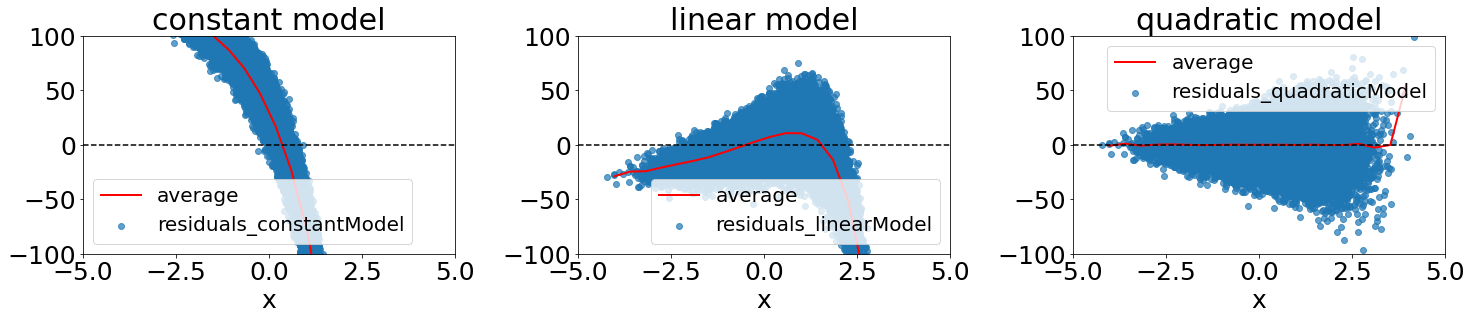

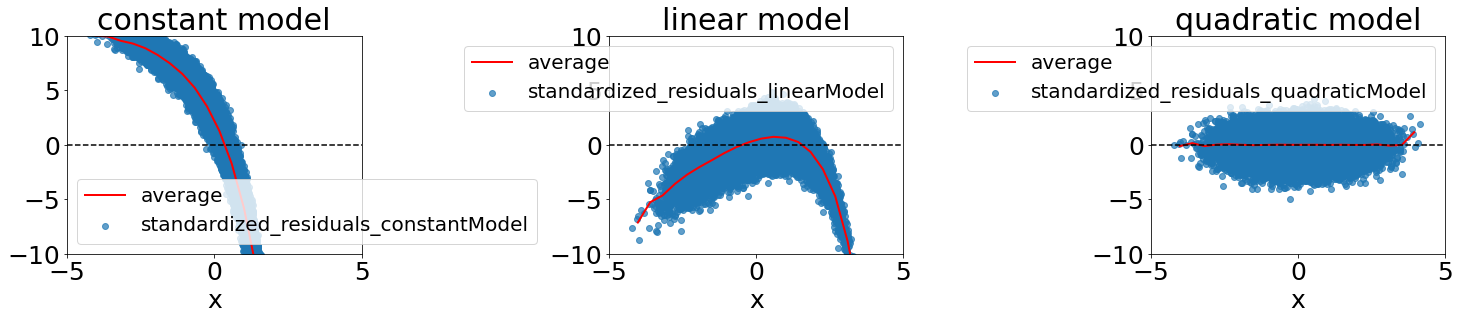

In [7]:
plt.rcParams.update({'font.size': 25})

def plot_residuals_vs_feature(ax, df, standardized, model_type):
    df = df[df['constrained'] == False]

    df['x_bin_midpoints'] = (pd
        .cut(df['x'], bins=20, labels=None)
        .apply(lambda x: (x.right + x.left) / 2)
    )

    residual_label = f'standardized_residuals_{model_type}Model' if standardized else f'residuals_{model_type}Model'    

    average_residual = df.groupby('x_bin_midpoints')[residual_label].mean()  

    ax.scatter(df['x'], df[residual_label], alpha=0.7, label=residual_label)
    ax.plot(average_residual.index, average_residual.values, color='red', lw=2, label=f'average') 
    ax.axhline(0, color='black', linestyle='--')
    ax.set_title(f'{model_type} model')
    ax.set_xlabel('x')
    ylim = (-10, 10) if standardized else (-100, 100) 
    ax.set_ylim(ylim)
    yticks = [-10, -5, 0, 5, 10] if standardized else [-100, -50, 0, 50, 100] 
    ax.set_yticks(yticks)
    ax.set_xlim(-5, 5)
    ax.legend(prop={'size': 20})

def plot_residuals_vs_feature_all_models(df, standardized): 
    fig, axes = plt.subplots(1, len(MODEL_TYPES), figsize=(7*len(MODEL_TYPES), 5))

    for i, model_type in enumerate(MODEL_TYPES):
        ax = axes[i]
        plot_residuals_vs_feature(
            ax, 
            df, 
            standardized, 
            model_type, 
        )

    plt.tight_layout()
    plt.show()

plot_residuals_vs_feature_all_models(DATA, standardized=False)
plot_residuals_vs_feature_all_models(DATA, standardized=True)

## Stratify neutral models' performances by x

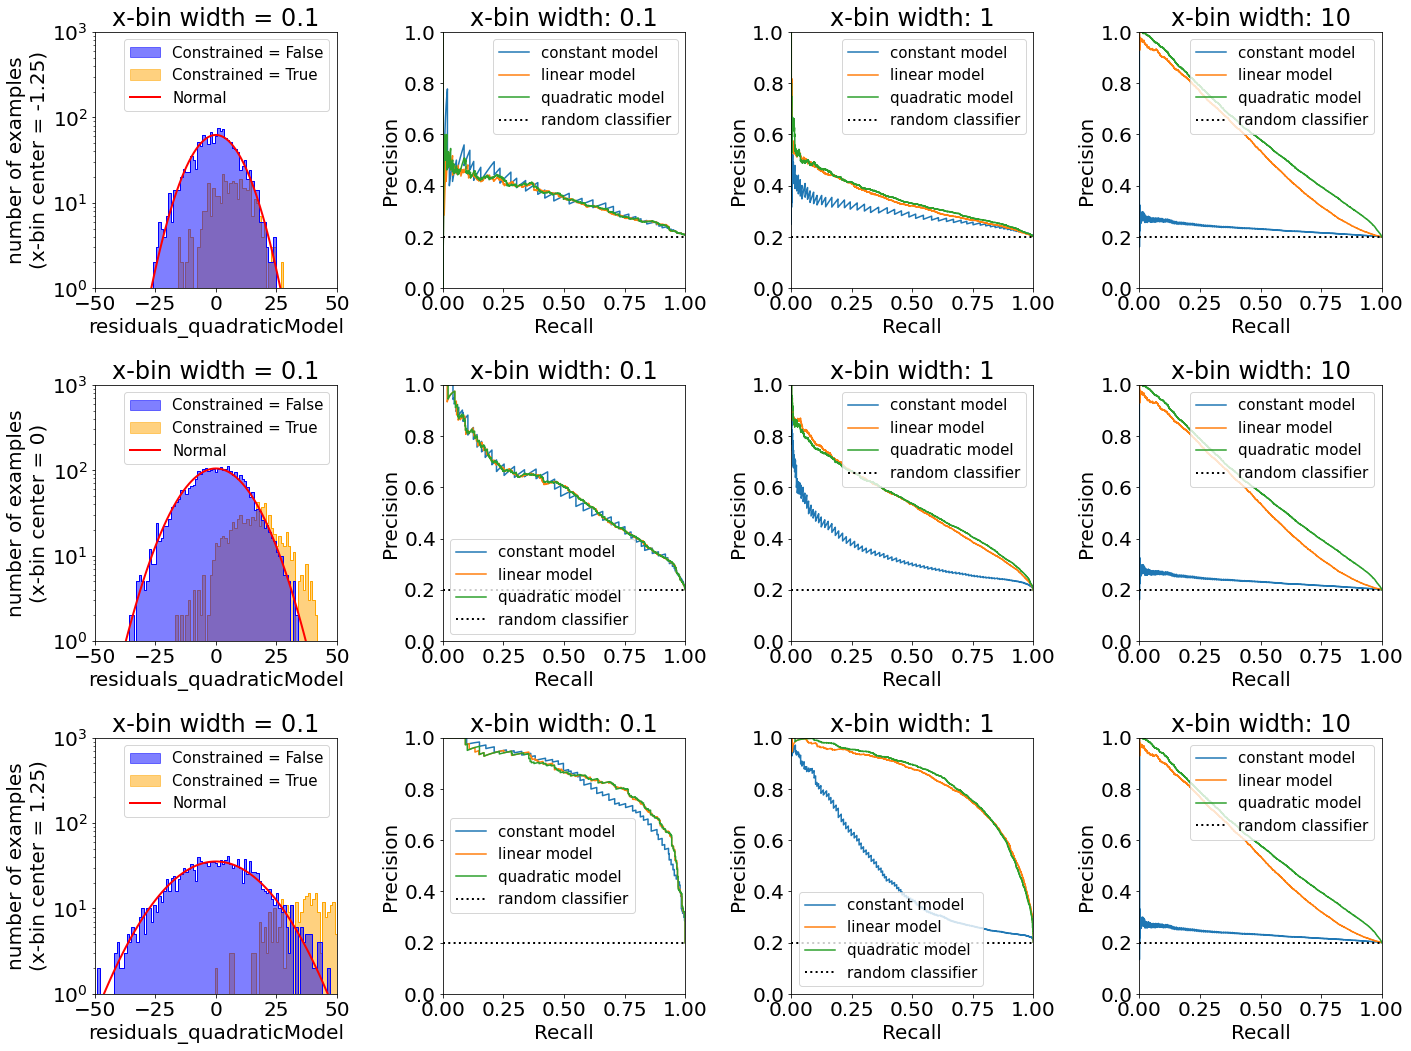

In [8]:
from sklearn.metrics import precision_recall_curve
import seaborn as sns
from matplotlib.patches import Patch

plt.rcParams.update({'font.size': 20})

NUMBER_EXAMPLES_MIN = 100

def filter_by_bin(df, bin_center, bin_width):
    left = bin_center - bin_width / 2
    right = bin_center + bin_width / 2
    df = df[
        (df['x'] >= left) & 
        (df['x'] < right)
    ]
    return df 

def normal_distribution(x, mu, sigma):
    return (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu) / sigma) ** 2)

def plot_residual_distributions(ax, df, standardized, xlim, model_type, title, ylabel, ylim):
    xlabel = f'standardized_residuals_{model_type}Model' if standardized else f'residuals_{model_type}Model'    

    bins = np.linspace(xlim[0], xlim[1], 100)         
    bin_centers = (bins[1:] + bins[:-1]) / 2
    bin_width = bins[1] - bins[0]

    palette = {False: 'blue', True: 'orange'}
    alpha = 0.5  

    sns.histplot(
        data=df, 
        x=xlabel, 
        hue='constrained', 
        kde=False, 
        element='step', 
        bins=bins, 
        ax=ax, 
        palette=palette, 
        alpha=alpha
    )

    # assumes the x in df are in the vicinity of x0, 
    # so that the average y value of the negative examples is a good estimate of TRUE_RATE(x0)
    lambda_ = df[df['constrained'] == False]['y'].mean()

    # Plot normal distribution
    x = bin_centers
    if standardized:
        y = normal_distribution(x, mu=0, sigma=1)
    else:
        y = normal_distribution(x, mu=0, sigma=np.sqrt(lambda_))            
    negative_class_count = len(df[df['constrained'] == False])
    y_scaled = y * negative_class_count * bin_width  
    normal_line, = ax.plot(x, y_scaled, color='red', lw=2)

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_yscale('log')  
    ax.set_xlim(xlim) 
    ax.set_ylim(ylim)
    ax.set_title(title)

    # Manually create legend handles and labels
    handles = [
        Patch(color=palette[False], alpha=alpha),
        Patch(color=palette[True], alpha=alpha),
        normal_line
    ]
    labels = [
        'Constrained = False', 
        'Constrained = True', 
        'Standard Normal' if standardized else 'Normal'
    ]
    ax.legend(handles=handles, labels=labels, prop={'size': 15})

def plot_pr_curve(ax, df, model_type):
    precision, recall, _ = precision_recall_curve(df['constrained'], df[f'standardized_residuals_{model_type}Model'])
    num_examples = len(df)

    if num_examples > NUMBER_EXAMPLES_MIN:
        ax.plot(recall, precision, label=f'{model_type} model')

def plot_pr_curve_wrapper(df): 
    bin_centers = [-1.25, 0, 1.25]

    bin_widths = [0.1, 1, 10]     
    # duplicate the first element so we can create two different plots for the smallest bin width:
    bin_widths.insert(0, bin_widths[0]) 
    
    fig, axes = plt.subplots(len(bin_centers), len(bin_widths), figsize=(5*len(bin_widths), 5*len(bin_centers)))

    for i, bin_center in enumerate(bin_centers):
        for j, bin_width in enumerate(bin_widths):
            df_filtered = filter_by_bin(df, bin_center, bin_width)
            ax = axes[i, j]
            if j == 0:
                plot_residual_distributions(
                    ax, 
                    df_filtered, 
                    standardized=False, 
                    xlim=(-50, 50), 
                    model_type='quadratic', 
                    title=f'x-bin width = {bin_width}', 
                    ylabel=(
                        'number of examples\n'
                        f'(x-bin center = {bin_center})'
                    ), 
                    ylim=(1, 1e3)
                )
            else: 
                for model_type in MODEL_TYPES:                
                    plot_pr_curve(ax, df_filtered, model_type)
                ax.plot([0, 1], [POSITIVE_FRACTION, POSITIVE_FRACTION], color='black', lw=2, linestyle=':', label='random classifier')
                ax.set_xlabel('Recall')
                ax.set_ylabel('Precision')
                ax.set_title(f'x-bin width: {bin_width}')
                ax.legend(prop={'size': 15})  
                ax.set_xlim(0, 1)
                ax.set_ylim(0, 1)
                
    plt.tight_layout()
    plt.show()

plot_pr_curve_wrapper(DATA)

## Model bias is responsible for poor overall performance 

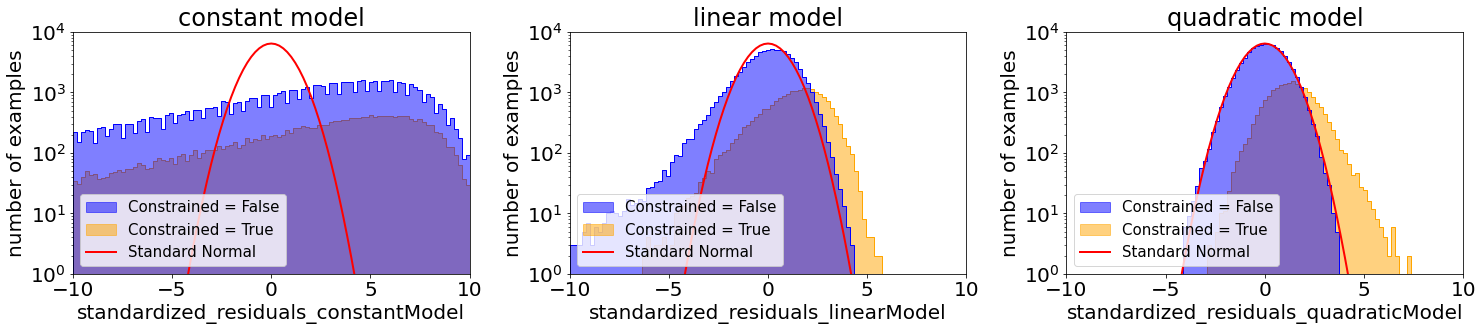

In [9]:
def plot_residual_distributions_all_models(df): 
    fig, axes = plt.subplots(1, len(MODEL_TYPES), figsize=(7*len(MODEL_TYPES), 5))

    for i, model_type in enumerate(MODEL_TYPES):
        ax = axes[i]
        plot_residual_distributions(
            ax, 
            df, 
            standardized=True, 
            xlim=(-10, 10), 
            model_type=model_type, 
            title=f'{model_type} model', 
            ylabel='number of examples', 
            ylim=(1, 1e4)
        )

    plt.tight_layout()
    plt.show()

plot_residual_distributions_all_models(DATA)

In [10]:
# TODO 
# compute PR curves using residuals, instead of standardized residuals

In [11]:
# TODO 
# Use simulation 3.2 to do a power analysis, showing that power (and SNR) is low when auPRC is low

In [12]:
# TODO 
# 1. stratify not by x, but by TRUE_RATE(x)
# 2. then infer the dependence of depletion on x from the divergence of the PR curves 

# TODO (related) 
# siepel has already inferred depletion (lambda_s), so learn a mapping from sequence to lambda_s

In [13]:
# TODO 
# preferentially choose the positive examples in proportion to x (just like enhancers are enriched in GC content), 
# rather than uniformly at random

In [14]:
# TODO 
# do simulation to mimic the experimental result that expected y goes up with gnocchi, but not observed y 